# Project Work, Part 3 - Data Quality

## Load Hourly Weather Data from Open-Meteo (ERA5)

In this section, we will use the **Open-Meteo API** to download historical hourly weather data — including **temperature**, **precipitation**, **wind speed**, and **wind direction** — for a given **latitude**, **longitude**, and **year**.

The data is based on the **ERA5 reanalysis model**, which provides high-quality, globally consistent meteorological data.

### The `load_weather_full()` Function

This function handles the following tasks:

- Requesting data from the **Open-Meteo archive API**
- Creating a **pandas.DataFrame** with hourly weather variables
- Indexing the data by **timestamp** (in local time for *Europe/Oslo*)

---

## Preparing Norwegian Cities Data (DataFrame)

We will create a DataFrame that includes:

- Names of the cities  
- Price zone codes  
- Longitude and latitude


In [2]:
# Importing Essential Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
# Aesthetic settings for plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
#  Creating Norwegian Cities Data

# Information for the five cities (from Norwegian price zones)
# You can modify the price area codes based on Elhub data or a previous project
cities_data = {
    "price_area_code": ["NO1", "NO2", "NO3", "NO4", "NO5"],
    "city_name": ["Oslo", "Kristiansand", "Trondheim", "Tromsø", "Bergen"],
    "latitude": [59.9139, 58.1467, 63.4305, 69.6492, 60.39299],
    "longitude": [10.7522, 7.9956, 10.3951, 18.9560, 5.32415]
}

# Convert the data into a DataFrame
df_cities = pd.DataFrame(cities_data)

# Display the result to verify
df_cities

,price_area_code,city_name,latitude,longitude
0,NO1,Oslo,59.91390,10.75220
1,NO2,Kristiansand,58.14670,7.99560
2,NO3,Trondheim,63.43050,10.39510
3,NO4,Tromsø,69.64920,18.95600
4,NO5,Bergen,60.39299,5.32415


### Downloading Historical Weather Data from Open-Meteo API


In [5]:
# Importing API Connection Libraries
import requests  
import datetime as dt  

# Function to Download Weather Data from Open-Meteo API

def download_weather_data(latitude: float, longitude: float, year: int):
    """
    Download historical weather data from the Open-Meteo API (ERA5 model)
    Includes the same variables used in Part 1 of the project.
    """

    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    url = "https://archive-api.open-meteo.com/v1/era5"

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": [
            "temperature_2m",
            "precipitation",
            "wind_speed_10m",
            "wind_gusts_10m",
            "wind_direction_10m"
        ],
        "timezone": "Europe/Oslo"
    }

    response = requests.get(url, params=params)

    if response.status_code != 200:
        raise Exception(f"Error connecting to the API: {response.status_code}")

    data = response.json()

    # Build a DataFrame similar to the previous file
    df_weather = pd.DataFrame({
        "time": pd.to_datetime(data["hourly"]["time"]),
        "temperature_2m (°C)": data["hourly"]["temperature_2m"],
        "precipitation (mm)": data["hourly"]["precipitation"],
        "wind_speed_10m (m/s)": data["hourly"]["wind_speed_10m"],
        "wind_gusts_10m (m/s)": data["hourly"]["wind_gusts_10m"],
        "wind_direction_10m (°)": data["hourly"]["wind_direction_10m"],
    })

    print(f"Weather data for year {year} downloaded successfully ({len(df_weather)} records)")
    return df_weather

## Testing Weather Data Download for Bergen (2019)

 **test the `download_weather_data` function** by retrieving weather data for **Bergen** in the year **2019**.


In [7]:
# Bergen coordinates from the previous DataFrame
lat_bergen = 60.39299
lon_bergen = 5.32415

# Download the data
df_bergen_2019 = download_weather_data(lat_bergen, lon_bergen, 2019)

df_bergen_2019.head()

Weather data for year 2019 downloaded successfully (8760 records)


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
0,2019-01-01 00:00:00,5.7,0.7,37.0,99.7,263
1,2019-01-01 01:00:00,5.8,0.2,41.0,107.3,278
2,2019-01-01 02:00:00,6.1,0.7,42.0,112.0,286
3,2019-01-01 03:00:00,6.3,0.5,40.9,105.8,298
4,2019-01-01 04:00:00,5.8,1.1,41.2,110.2,315


In [8]:
df_bergen_2019.columns

Index(['time', 'temperature_2m (°C)', 'precipitation (mm)',
       'wind_speed_10m (m/s)', 'wind_gusts_10m (m/s)',
       'wind_direction_10m (°)'],
      dtype='object')

In [9]:
df_bergen_2019.isna().sum()

time                      0
temperature_2m (°C)       0
precipitation (mm)        0
wind_speed_10m (m/s)      0
wind_gusts_10m (m/s)      0
wind_direction_10m (°)    0
dtype: int64

In [10]:
df_bergen_2019.describe()

,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
count,8760,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2019-07-02 11:30:00,7.831689,0.246518,10.688402,29.528185,186.517123
min,2019-01-01 00:00:00,-12.900000,0.000000,0.000000,2.500000,1.000000
25%,2019-04-02 05:45:00,3.100000,0.000000,6.100000,16.900000,117.000000
50%,2019-07-02 11:30:00,7.200000,0.000000,9.500000,26.600000,165.000000
75%,2019-10-01 17:15:00,12.100000,0.200000,14.300000,39.600000,279.000000
max,2019-12-31 23:00:00,31.700000,9.500000,46.700000,131.000000,360.000000
std,NaN,5.999381,0.583165,6.055750,16.107459,96.202031


# Function for Outlier Analysis using DCT + SPC

This function detects **temperature outliers** by combining **signal processing** (via DCT) and **statistical process control (SPC)** techniques.

### Method Overview

The process involves the following steps:

1. **Apply a Discrete Cosine Transform (DCT)** to the temperature series.
2. **Remove low-frequency (seasonal) components** using a high-pass filter to focus on anomalies rather than long-term trends.
3. **Reconstruct the signal** using the inverse DCT (IDCT).
4. **Set SPC-style bounds** using a **robust MAD-based (Median Absolute Deviation)** spread estimate.
5. **Identify and highlight outliers** — points that lie outside the upper and lower control limits.
6. **Plot the original and filtered series**, with detected outliers visually marked.
7. **Return a DataFrame** containing only the outlier rows.


In [ ]:
def plot_temperature_outliers(df, column="temperature_2m (°C)", 
                              cutoff=0.02, n_std=3.5, show_summary=True):
    """
    Detect temperature outliers using a DCT high-pass filter.
    
    Parameters:
        df (DataFrame): Weather data containing 'time' and temperature columns.
        column (str): Name of the temperature column.
        cutoff (float): Fraction of low frequencies to remove (0.0–1.0).
        n_std (float): Number of MAD-based standard deviations for thresholding.
        show_summary (bool): Whether to print a summary of detected outliers.
    
    Returns:
        DataFrame: Subset of outlier records.
        Also displays a plot and summary statistics.
    """

    # Ensure the column exists
   
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")

    temp = df[column].values
    temp_dct = dct(temp, norm="ortho")

    N = len(temp_dct)
    cutoff_index = int(N * cutoff)

    # --- LOW-PASS TREND ---
    trend_dct = np.copy(temp_dct)
    trend_dct[cutoff_index:] = 0              # keep only low frequencies
    trend = idct(trend_dct, norm="ortho")     # smooth trend estimate

    # --- MAD THRESHOLDS ---
    mad = np.median(np.abs(temp - trend))
    upper_bound = trend + n_std * mad
    lower_bound = trend - n_std * mad

    # --- OUTLIERS ---
    is_outlier = (temp < lower_bound) | (temp > upper_bound)
    outliers = df[is_outlier]

    # --- PLOT ---
    plt.figure(figsize=(14, 6))
    plt.plot(df["time"], temp, label="Temperature (°C)", alpha=0.8)

    plt.plot(df["time"], trend, label="Trend (low-pass)", alpha=0.9,color="lime" )

    plt.plot(df["time"], upper_bound, "--", linewidth=1, color="tomato",
             label="Upper SPC limit")
    plt.plot(df["time"], lower_bound, "--", linewidth=1,
             label="Lower SPC limit", color="tomato")

    plt.scatter(outliers["time"], outliers[column], color="teal", s=12, 
                label="Outliers")

    plt.title("Temperature with Time-Varying SPC Limits (Low-Pass DCT Trend)")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if show_summary:
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of data: {100 * len(outliers) / len(df):.2f}%")
        print(f"MAD: {mad:.3f}")

    return outliers

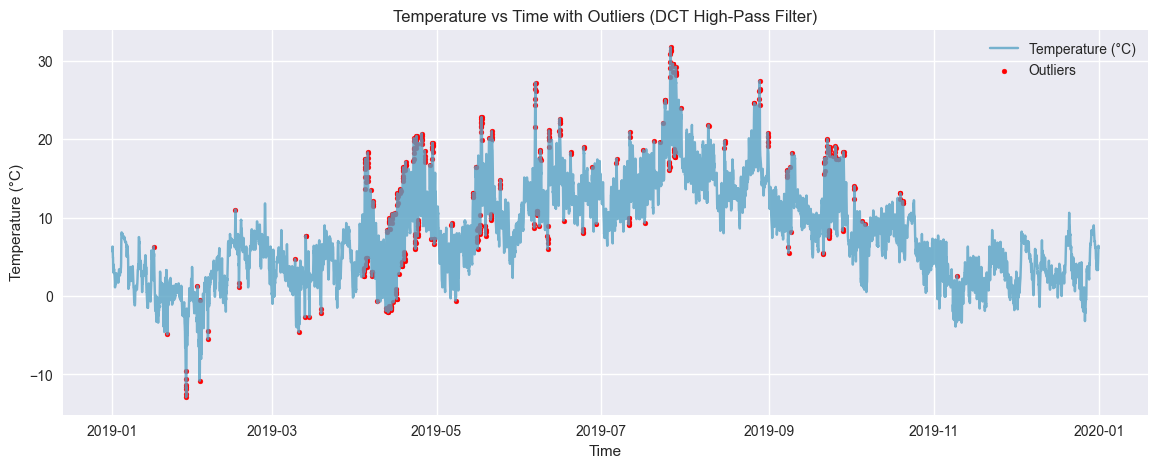

Number of outliers: 428
Percentage of data: 4.89%
Lower bound: -4.78 | Upper bound: 4.54


In [13]:
# Test the function on Bergen 2019 data

outliers_bergen = plot_temperature_outliers(
    df_bergen_2019, 
    column="temperature_2m (°C)",
    cutoff=0.02,     # fraction of low frequencies to remove
    n_std=3.5        # MAD-multiples threshold for outliers
)


In [14]:
outliers_bergen.head(3)

,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
369,2019-01-16 09:00:00,6.3,0.9,20.5,52.6,214
490,2019-01-21 10:00:00,-4.9,0.0,5.4,7.6,127
653,2019-01-28 05:00:00,-10.6,0.0,5.2,10.4,74


In [15]:
from sklearn.neighbors import LocalOutlierFactor
# Detecting Precipitation Anomalies (LOF)

def plot_precipitation_anomalies(df, column="precipitation (mm)", contamination=0.01, show_summary=True):
    """
    Detect precipitation anomalies using the Local Outlier Factor (LOF) algorithm.
    
    Parameters:
        df (DataFrame): Weather data containing 'time' and precipitation columns.
        column (str): Name of the precipitation column.
        contamination (float): Expected proportion of outliers (e.g., 0.01 = 1%).
        show_summary (bool): Whether to print a summary of detected anomalies.
    
    Returns:
        DataFrame: A subset of outlier records.
        Also displays a plot and summary statistics.
    """

    # Check if the required column exists ---
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")

    # Prepare data for the LOF algorithm ---
    X = df[[column]].values  # use only the precipitation column

    # Create the LOF model
    lof = LocalOutlierFactor(n_neighbors=20, contamination=contamination)

    # Predict outliers (-1 = outlier, 1 = normal)
    y_pred = lof.fit_predict(X)

    # Identify outlier rows
    is_outlier = y_pred == -1
    outliers = df[is_outlier]

    # Plot results ---
    plt.figure(figsize=(14, 5))
    plt.plot(df["time"], df[column], label="Precipitation (mm)", color="#3389EA", alpha=0.7)
    plt.scatter(outliers["time"], outliers[column], color="red", label="Outliers", s=15)
    plt.title(f"Precipitation vs Time with LOF Outliers (contamination={contamination})")
    plt.xlabel("Time")
    plt.ylabel("Precipitation (mm)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Summary ---
    if show_summary:
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of data: {100 * len(outliers) / len(df):.2f}%")
        print("Top 5 anomalous values:")
        display(outliers.sort_values(column, ascending=False).head())

    return outliers

C:\Users\Majed\anaconda3\envs\ind320\lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


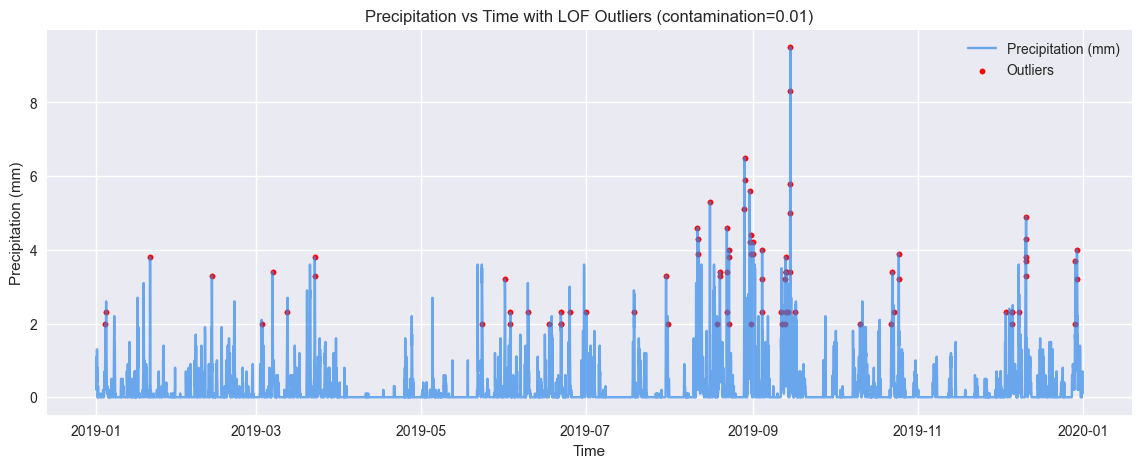

Number of outliers: 85
Percentage of data: 0.97%
Top 5 anomalous values:


,time,temperature_2m (°C),precipitation (mm),wind_speed_10m (m/s),wind_gusts_10m (m/s),wind_direction_10m (°)
6163,2019-09-14 19:00:00,11.9,9.5,24.4,74.2,194
6162,2019-09-14 18:00:00,11.3,8.3,28.4,74.9,179
5757,2019-08-28 21:00:00,17.5,6.5,10.5,41.8,176
5756,2019-08-28 20:00:00,17.7,5.9,10.9,43.6,153
6161,2019-09-14 17:00:00,11.1,5.8,27.4,70.2,182


In [16]:
# Test the function on Bergen 2019 data

outliers_precip = plot_precipitation_anomalies(
    df_bergen_2019,
    column="precipitation (mm)",
    contamination=0.01  
)

## Function for Seasonal Trend Analysis using STL

This function performs **Seasonal–Trend decomposition using Loess (STL)** on electricity production data to separate the observed series into **Trend (Tₜ)**, **Seasonal (Sₜ)**, and **Residual (Rₜ)** components.

### Model
\[
y_t = T_t + S_t + R_t
\]

- **Tₜ (Trend):** Long-term direction.
- **Sₜ (Seasonal):** Repeating pattern (e.g., daily/weekly/annual).
- **Rₜ (Residual):** Irregular variation/noise after removing trend and seasonality.

---

In [18]:
#  load production data
elhub_df = pd.read_csv("elhub_production.csv")
elhub_df.head()

,Unnamed: 0,startTime,endTime,lastUpdatedTime,priceArea,productionGroup,quantityKwh
0,0,2021-01-01 00:00:00+01:00,2021-01-01 01:00:00+01:00,2024-12-20 10:35:40+01:00,NO1,hydro,2507716.8
1,1,2021-01-01 01:00:00+01:00,2021-01-01 02:00:00+01:00,2024-12-20 10:35:40+01:00,NO1,hydro,2494728.0
2,2,2021-01-01 02:00:00+01:00,2021-01-01 03:00:00+01:00,2024-12-20 10:35:40+01:00,NO1,hydro,2486777.5
3,3,2021-01-01 03:00:00+01:00,2021-01-01 04:00:00+01:00,2024-12-20 10:35:40+01:00,NO1,hydro,2461176.0
4,4,2021-01-01 04:00:00+01:00,2021-01-01 05:00:00+01:00,2024-12-20 10:35:40+01:00,NO1,hydro,2466969.2


In [19]:
elhub_df.isnull().sum()

Unnamed: 0         0
startTime          0
endTime            0
lastUpdatedTime    0
priceArea          0
productionGroup    0
quantityKwh        0
dtype: int64

In [20]:
from statsmodels.tsa.seasonal import STL

def stl_decompose_simple(
    df,
    area="NO1",
    production_group="hydro",
    period_length=24*7,
    seasonal=25,
    trend=601,
    robust=True
):
    """
    Perform STL (Seasonal-Trend decomposition using Loess) on Elhub-style
    electricity production data and return both the figure and result object.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing at least:
        ['startTime', 'priceArea', 'productionGroup', 'quantityKwh'].
    area : str, default="NO1"
        Electricity price area to filter (e.g., "NO1", "NO2", ...).
    production_group : str, default="hydro"
        Production group to analyze (e.g., "hydro", "wind", "solar").
    period_length : int, default=24*7
        Period (in hours) for the seasonal component — here one week.
    seasonal : int, default=25
        Length of the seasonal smoother.
    trend : int, default=601
        Length of the trend smoother.
    robust : bool, default=True
        Whether to use a robust fitting method to reduce the impact of outliers.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The Matplotlib figure displaying trend, seasonal, and residual components.
    result : statsmodels.tsa.seasonal.STLResult
        The STL decomposition result object containing component series.
    s"""

    # Convert and clean datetime
    df["startTime"] = pd.to_datetime(df["startTime"], errors="coerce", utc=True)
    df = df.dropna(subset=["startTime"]).set_index("startTime").sort_index()

    # Filter data
    sub = df[(df["priceArea"] == area) & (df["productionGroup"] == production_group)]
    if sub.empty:
        print("No data found for this area or production group.")
        return None, None

    # Prepare numeric values
    y = pd.to_numeric(sub["quantityKwh"], errors="coerce")
    y = y.resample("h").sum().interpolate()

    # Run STL
    stl = STL(y, period=period_length, seasonal=seasonal, trend=trend, robust=robust)
    result = stl.fit()

    # Plot
    fig = result.plot()
    fig.set_size_inches(12, 8)
    fig.suptitle(f"STL Decomposition — {production_group.capitalize()} ({area})", fontsize=14)

    # Close figure 
    plt.close(fig)

    return fig, result

In [21]:
fig, res = stl_decompose_simple(
    elhub_df,
    area="NO5",
    production_group="hydro",
    period_length=24*7,  # one week of hourly data
    seasonal=25,
    trend=601,
    robust=True
)

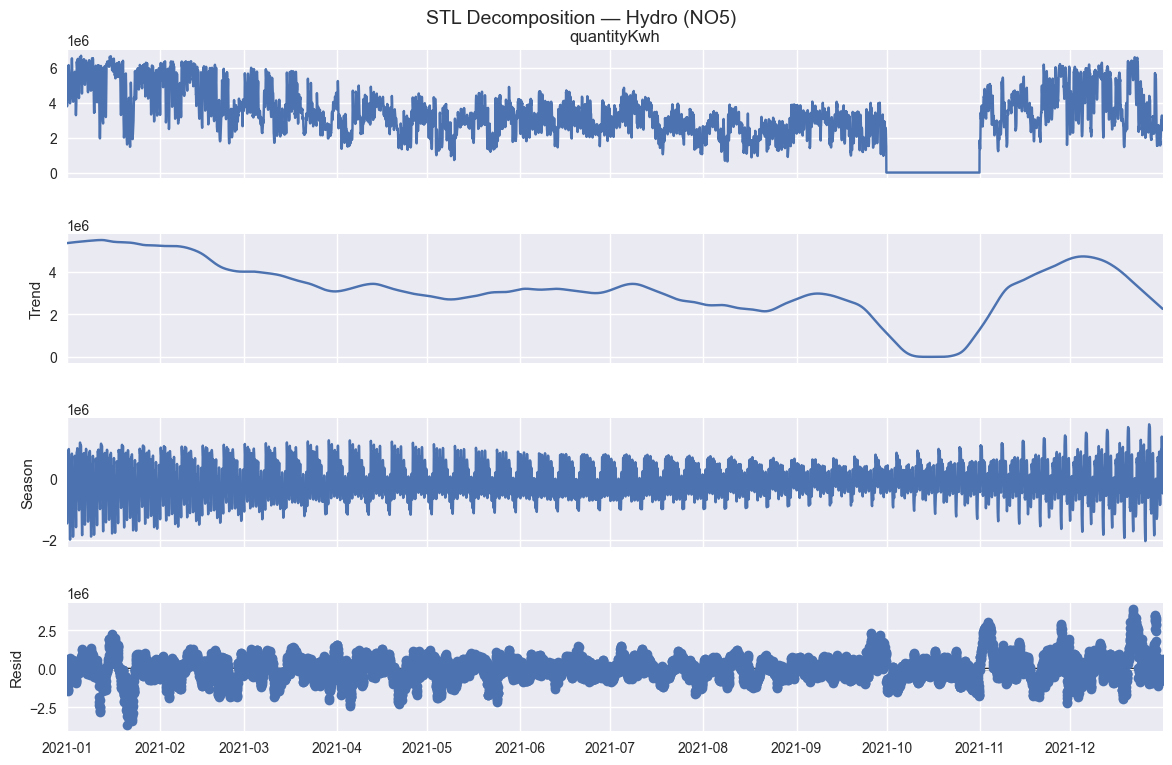

In [22]:
fig

## Spectrogram for Elhub Production Data

Build a spectrogram for hourly Elhub production series filtered by **price area** and **production group**.

### Improvements vs. original
- **Correct time/frequency units:** Internally use 1 sample/hour; plot in **days** and **cycles/day** for interpretability.
- **Edge-case handling:** Auto-adjust `nperseg` when the series is short; clamp `noverlap`; return `None` if insufficient data.
- **Robust preprocessing:** Coerce to numeric, resample hourly, interpolate gaps.
- **Optional log scaling:** Better dynamic range for plots with large amplitude contrasts.
- **Deterministic colormap & closed figure:** Prevents double display in notebooks and supports headless environments.


In [24]:
from scipy.signal import spectrogram

def production_spectrogram(
    df: pd.DataFrame,
    area: str = "NO1",
    production_group: str = "hydro",
    nperseg: int = 256,                  # window length (samples)
    noverlap: int = 128,                 # window overlap (samples)
    
    time_col: str = "startTime",
    area_col: str = "priceArea",
    group_col: str = "productionGroup",
    value_col: str = "quantityKwh",
):
    """
    Build a spectrogram for Elhub production data and return a Matplotlib Figure.

    Parameters
    ----------
    df : pd.DataFrame
        Table with at least [time_col, area_col, group_col, value_col].
    area : str
        Electricity price area filter (e.g. "NO1").
    production_group : str
        Production group filter (e.g. "hydro", "wind", ...).
    nperseg : int
        Window length in samples (hourly data ⇒ samples are hours).
    noverlap : int
        Overlap between windows in samples.
    time_col, area_col, group_col, value_col : str
        Column names in `df`.

    Returns
    -------
    fig : matplotlib.figure.Figure | None
        Figure of the spectrogram, or None if no data matches the filters.
    """

    # Copy & parse time
    s = df.copy()
    s[time_col] = pd.to_datetime(s[time_col], errors="coerce", utc=True)
    s = s.dropna(subset=[time_col])

    # Filter by area and production group
    s = s[(s[area_col] == area) & (s[group_col] == production_group)]
    if s.empty:
        return None

    # Build a time-indexed series, hourly and numeric
    ts = pd.DataFrame({
        time_col: s[time_col].values,
        "value": pd.to_numeric(s[value_col], errors="coerce"),
    }).dropna()

    ts = ts.set_index(time_col).sort_index()
    ts = ts.resample("h").sum().interpolate(limit_direction="both")

    x = ts["value"].astype(float).to_numpy()
    if x.size == 0:
        return None

    # Sampling rate: hourly ⇒ 24 samples/day
    fs = 24.0

    # Clamp overlap
    noverlap = max(0, min(noverlap, nperseg - 1))

    # Spectrogram
    f, t, Sxx = spectrogram(
        x, fs=fs, nperseg=nperseg, noverlap=noverlap,
        scaling="density", mode="magnitude"
    )

    # Plot
    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.pcolormesh(t, f, Sxx, shading="gouraud", cmap="viridis")
    ax.set_title(f"Spectrogram — {production_group.capitalize()} ({area})")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Frequency (cycles/day)")
    fig.colorbar(im, ax=ax, label="Magnitude")
    fig.tight_layout()

    # Prevent double display in notebooks
    plt.close(fig)
    return fig

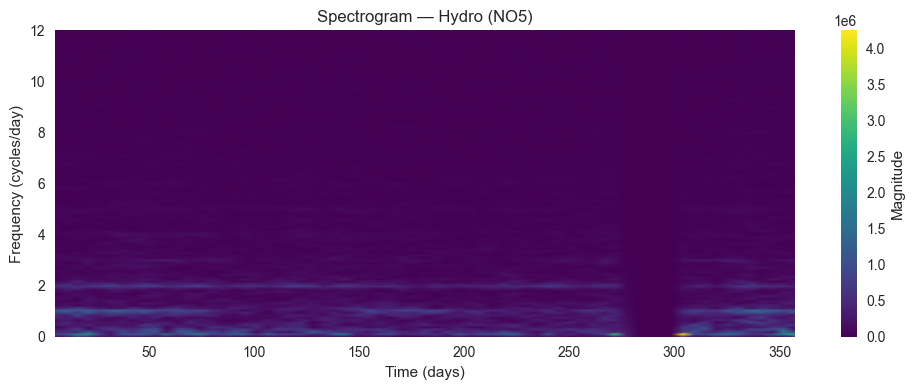

In [25]:
fig_spec = production_spectrogram(
    elhub_df,
    area="NO5",
    production_group="hydro",
    nperseg=256,          
    noverlap=128,        
    time_col="startTime",
    area_col="priceArea",
    group_col="productionGroup",
    value_col="quantityKwh",
)

fig_spec

## Development Log – Jupyter Notebook & Streamlit App (IND320)

In this project, I used **Jupyter Notebook** and **Streamlit** to work with weather data for 2021. The main goal was to download data from the Open-Meteo API and do some analysis like trend detection and anomaly detection.

I started in Jupyter Notebook. It was easy to try out code there and test different ideas. I used **STL decomposition** to break the data into trend, seasonality, and residuals. It helped me understand how temperature and wind speed change over time. I also made a **spectrogram** using `scipy` to see repeating patterns and how they change.

After that, I worked on finding outliers. First, I used **SPC (Statistical Process Control)** to find values that are too high or too low using the 3-sigma rule. Then I used a machine learning method called **LOF (Local Outlier Factor)** from `sklearn` to detect more complex anomalies in the data.

When I finished testing in Jupyter, I started building the **Streamlit app**. I made several pages. The first important page lets the user pick a city (like Oslo or Bergen), and then the app downloads weather data for that city using the Open-Meteo API. The data is saved in memory and used in other pages.

I made two main pages after that:
- **Page A** has two tabs: one for STL decomposition and another for the spectrogram.
- **Page B** has two tabs too: one for outliers using SPC and one for anomalies using LOF.

I didn’t rewrite everything. I **reused some functions** from my Jupyter work. I put them in a file called `utils_analysis.py` and used them in the Streamlit app. This made the code cleaner and saved time.

Working with Jupyter was simple. It helped me understand the data and try code step-by-step. Streamlit was more difficult at first, especially saving user selections across pages. But after learning about `st.session_state`, it worked well.

In the end, the app lets users pick a location, get real weather data, and see patterns and anomalies in a nice way. It was interesting to see how I could turn a notebook into a working app with real data and interactive features.


##  Use of AI Tools (ChatGPT)

During this project, I used ChatGPT as a support tool to help me understand certain concepts related to data analysis, such as STL decomposition, anomaly detection, and how to use the Open-Meteo API. I also used it when I faced coding issues in Python. For example, it helped me understand and solve an error related to the file path when trying to load a CSV file.

I did not use AI to generate the final results or answers directly. All analysis, decisions, and final implementations were done by me. The AI was used only to support my learning and help me troubleshoot technical problems.

I have made sure that all code and conclusions reflect my own understanding and effort.
